In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

https://medium.com/@datadote/pytorch-matrix-factorization-pictures-code-part-1-abe331317ffb

https://github.com/Datadote/matrix-factorization-pytorch/blob/master/01_matrix_fact_simple.ipynb

In [2]:
user_item_interactions_df = pd.read_csv('../tests/test_data/user_item_interactions.csv', parse_dates=['date'])

user_item_interactions_df.head()

,user_id,item_id,date,count
0,U002120,I00006767,2024-07-02,1.0
1,U000748,I00001418,2024-07-02,1.0
2,U004334,I00002579,2024-07-02,1.0
3,U002062,I00000098,2024-07-02,1.0
4,U001214,I00009416,2024-07-02,1.0


In [ ]:
# filter interactions to include only users with >= 15 interactions

interactions = user_item_interactions_df.groupby('user_id').filter(lambda x: len(x) >= 15)

# sort for train test split
interactions = interactions.sort_values(['user_id', 'date'], ascending=[True, True]).reset_index(drop=True)

# create ratings column
interactions['rating'] = np.clip(interactions['count'], a_max=5, a_min=1) / 5
interactions.drop(['count', 'date'], axis=1, inplace=True)

unique_users = interactions.user_id.drop_duplicates()
unique_items = interactions.item_id.drop_duplicates()

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

interactions['user_id'] = user_encoder.fit_transform(interactions['user_id'])
interactions['item_id'] = item_encoder.fit_transform(interactions['item_id'])

print(unique_users.shape, unique_items.shape, interactions.shape)

interactions.head()

(58,) (1711,) (1714, 3)


,user_id,item_id,rating
0,0,637,0.2
1,0,185,0.2
2,0,76,0.2
3,0,1362,0.2
4,0,202,0.2


In [4]:
df_train = interactions.groupby('user_id').head(-5).reset_index(drop=True)
df_val = interactions.groupby('user_id').tail(5).reset_index(drop=True)
df_train.shape, df_val.shape

((1424, 3), (290, 3))

In [5]:
class UserItemDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df[['user_id', 'item_id', 'rating']]
        self.X = list(zip(df.user_id.values, df.item_id.values))
        self.y = self.df.rating.values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
batch_size = 128
ds_train = UserItemDataset(df_train)
ds_val = UserItemDataset(df_val)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
class MF(torch.nn.Module):
    """ Matrix factorization model """
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_embeddings=n_users, embedding_dim=embedding_dim)
        self.item_embedding = torch.nn.Embedding(num_embeddings=n_items, embedding_dim=embedding_dim)
    def forward(self, user, item):
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        return (user_embedding*item_embedding).sum(1)

In [8]:
n_users = len(unique_users)
n_items = len(unique_items)

model = MF(n_users, n_items, embedding_dim=32)
model.to(device)
model

MF(
  (user_embedding): Embedding(58, 32)
  (item_embedding): Embedding(1711, 32)
)

In [9]:
LEARNING_RATE = 0.2
NUM_EPOCHS = 20

opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss()
epoch_train_losses, epoch_val_losses = [], []

for i in range(NUM_EPOCHS):
    train_losses, val_losses = [], []
    model.train()
    for xb,yb in dl_train:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = model(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    model.eval()
    for xb,yb in dl_val:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = model(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        val_losses.append(loss.item())
    # Start logging
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    print(f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}, Val Loss:{epoch_val_loss:0.1f}')

Epoch: 0, Train Loss: 23.2, Val Loss:22.8
Epoch: 1, Train Loss: 51.4, Val Loss:10.3
Epoch: 2, Train Loss: 46.0, Val Loss:5.8
Epoch: 3, Train Loss: 17.3, Val Loss:4.4
Epoch: 4, Train Loss: 7.5, Val Loss:3.4
Epoch: 5, Train Loss: 4.6, Val Loss:2.2
Epoch: 6, Train Loss: 2.3, Val Loss:2.0
Epoch: 7, Train Loss: 1.1, Val Loss:1.0
Epoch: 8, Train Loss: 0.4, Val Loss:0.7
Epoch: 9, Train Loss: 0.3, Val Loss:0.6
Epoch: 10, Train Loss: 0.1, Val Loss:0.5
Epoch: 11, Train Loss: 0.1, Val Loss:0.5
Epoch: 12, Train Loss: 0.0, Val Loss:0.4
Epoch: 13, Train Loss: 0.0, Val Loss:0.4
Epoch: 14, Train Loss: 0.0, Val Loss:0.4
Epoch: 15, Train Loss: 0.0, Val Loss:0.5
Epoch: 16, Train Loss: 0.0, Val Loss:0.3
Epoch: 17, Train Loss: 0.0, Val Loss:0.3
Epoch: 18, Train Loss: 0.0, Val Loss:0.3
Epoch: 19, Train Loss: 0.0, Val Loss:0.3


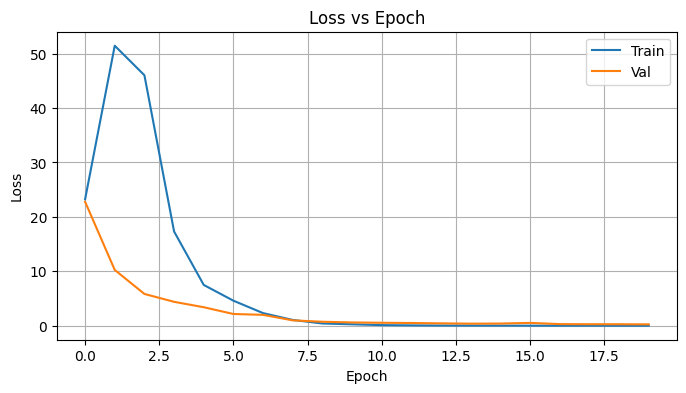

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(epoch_train_losses, label='Train')
plt.plot(epoch_val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [11]:
user_embedding_min_weight = model.user_embedding.weight.min().item()
user_embedding_max_weight = model.user_embedding.weight.max().item()
item_embedding_min_weight = model.item_embedding.weight.min().item()
item_embedding_max_weight = model.item_embedding.weight.max().item()
print(f'User embedding min/max weight: {user_embedding_min_weight:0.3f} / {user_embedding_max_weight:0.3f}')
print(f'Item embedding min/max weight: {item_embedding_min_weight:0.3f} / {item_embedding_max_weight:0.3f}')
print(f'Predictions min/max: {preds.min().item():0.2f} / {preds.max().item():0.2f}')
print(f'Rating min/max: {yRatings.min().item():0.2f} / {yRatings.max().item():0.2f}')
print(preds.detach().cpu().numpy()[:6])
print(yRatings.detach().cpu().numpy()[:6])

User embedding min/max weight: -0.542 / 0.599
Item embedding min/max weight: -2.948 / 3.432
Predictions min/max: -0.89 / 0.68
Rating min/max: 0.20 / 0.60
[-0.08785623 -0.88764054  0.00539791  0.29495484  0.26938397  0.6845105 ]
[0.2 0.2 0.2 0.2 0.2 0.2]


In [ ]:
class MF2(torch.nn.Module):
    """ Matrix factorization model """
    def __init__(self, n_users, n_items, embedding_dim, init_weights = False, use_bias = False, sigmoid_high = None, sigmoid_low = 0):
        super().__init__()
        self.use_bias = use_bias
        self.sigmoid_high = sigmoid_high
        self.sigmoid_low = sigmoid_low
        self.user_embedding = torch.nn.Embedding(num_embeddings=n_users, embedding_dim=embedding_dim)
        self.item_embedding = torch.nn.Embedding(num_embeddings=n_items, embedding_dim=embedding_dim)
        if use_bias:
            self.user_bias = torch.nn.Parameter(torch.zeros(n_users))
            self.item_bias = torch.nn.Parameter(torch.zeros(n_items))
            self.offset = torch.nn.Parameter(torch.zeros(1))
        if init_weights:
            self.user_embedding.weight.data.uniform_(0., 0.05)
            self.item_embedding.weight.data.uniform_(0., 0.05)

    def forward(self, user, item):
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        product = (user_embedding*item_embedding).sum(1)
        if self.use_bias:
            product = self.apply_bias(product, user, item)
        if self.sigmoid_high is not None:
            product = self.apply_sigmoid_range(product)
        return product
    
    def apply_bias(self, x, user, item):
        return x + self.user_bias[user] + self.item_bias[item] + self.offset
    
    def apply_sigmoid_range(self, x):
        return torch.sigmoid(x) * (self.sigmoid_high - self.sigmoid_low) + self.sigmoid_low

In [ ]:
LEARNING_RATE = 0.2
NUM_EPOCHS = 20
INIT_WEIGHTS = True
USE_BIAS = True
SIGMOID_HIGH = 5.5